# Tabular Value-Based Reinforcement Learning

Source: https://datamachines.xyz/the-hands-on-reinforcement-learning-course-page/

The q-value function Q(s, a) associated with a policy π is the total reward the agent expects to get when at state s the agent takes action a and follows policy π thereafter.

The optimal q-value function Q*(s, a) is the q-value function associated with the optimal policy π*.

If you know Q*(s, a) you can infer π*: i.e. you pick as the next action the one that maximizes Q*(s, a) for the current state s.

Q-learning is an iterative algorithm to compute better and better approximations to the optimal q-value function Q*(s, a), starting from an arbitrary initial guess Q⁰(s, a). __(Bellman equation)__

<img src="fig/qfun.png" width=500 height=500 />

In a tabular environment with a finite number of states and actions, a q-function is essentially a matrix. It has as many rows as states and columns as actions

Ok, but how exactly do you compute the next approximation Q¹(s, a) from Q⁰(s, a)?

* Learn from examples, lots of examples.
* Lots of 5 or 4 -tuples: state, action, reinforcement, next state, next action ($s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1}$) __SARSA__ or __Q-learning__ ($s_t, a_t, r_{t+1}, s_{t+1}$).

- **Monte Carlo:** Assign to each state-action pair an average of the observed returns: $ \;\;\;\text{value}(s_t,a_t) \approx \text{mean of } R(s_t,a_t)$
  
-  **Temporal Difference (TD):** Using $\text{value}(s_{t+1},a_{t+1})$ as estimate of return from next state, update current state-action value: $\;\;\; \text{value}(s_t,a_t) \approx r_{t+1} + \text{value}(s_{t+1},a_{t+1})$


In [ ]:
done = False
while not done:
    action = agent.get_action(state, epsilon_)
    next_state, reward, done, info = env.step(action)

    agent.update_parameters(state, action, reward, next_state, epsilon_)

    rewards += reward
    if next_state[0] > max_position:
        max_position = next_state[0]

    state = next_state

## Q-learning agent (Off-policy)

As our q-agent navigates the environment and observes the next state s’ and reward r, you update your q-value matrix with this formula.

<img src="fig/nqfun.png" width=500 height=500 />


__What is the learning rate 𝛼 in this formula?__

It controls how large are the updates to the q-function. You need to tune it, as too large of a value will cause unstable training, and too small might not be enough to escape __local minima__.

__And this discount factor 𝛾?__

The discount factor is a (hyper) parameter between 0 and 1 that determines how much our agent cares about rewards in the distant future relative to those in the immediate future.

When 𝛾=0, the agent only cares about maximizing immediate reward. As it happens in life, maximizing immediate reward is not the best recipe for optimal long-term outcomes. This happens in RL agents too.

When 𝛾=1, the agent evaluates each of its actions based on the sum total of all of its future rewards. In this case the agent weights equally immediate rewards and future rewards.
The discount factor is typically an intermediate value, e.g. 0.6.

## SARSA agent (On-policy)

<img src="fig/sarsa.png" width=500 height=500 />

In [ ]:
def get_action(self, state, epsilon=None):
    if epsilon and random.uniform(0, 1) < epsilon:
        # Explore action space
        action = self.env.action_space.sample()
    else:
        # Exploit learned values
        action = np.argmax(self.q_table[state[0]])
        
    return action

def update_parameters(self, state, action, reward, next_state, epsilon):
    
    na = self.get_action(next_state, epsilon)

    delta = self.alpha * (
            reward
            + self.gamma * self.q_table[next_state[0], na]
            - self.q_table[state[0], action]
    )
    self.q_table[state[0], action] += delta

## Tabular Q for the Maze Problem

In [1]:
%%writefile maze1.txt
************
*          *
*          *
*        * *
*        * *
*        * *
*     **** *
*     * G* *
*     *  * *
*     *  * *
*          *
************

Overwriting maze1.txt


In [2]:
!cat maze1.txt

************
*          *
*          *
*        * *
*        * *
*        * *
*     **** *
*     * G* *
*     *  * *
*     *  * *
*          *
************


How do we implement the Q function?  For the maze problem, we know we can

   *  enumerate all the states (positions) the set of which is finite ($10\cdot 10$),
   *  enumerate all actions, the set of which is finite (4),
   *  calculate the new state from the old state and an action, and
   *  represent in memory all state-action combinations ($10\cdot 10\cdot 4$).

So, let's just store the Q function in table form.

The Q table will need three dimensions, for $x$, $y$, and the action.

    Qold = Q[stateOld[0], stateOld[1], actionOld]
    Qnew = Q[state[0], state[1], action]
    TDError = r + Qnew - Qold
    Q[stateOld[0], stateOld[1], actionOld] = Qold + rho * TDError

For our agent to interact with its world, we must implement the steps

   1.  Initialize Q.
   1.  Choose random, non-goal, state.
   1. Repeat:
       1. If at goal,
        1. Update Qold with TD error (1 - Qold)
        1. Pick new random state
       1. Otherwise (not at goal),
         1. Select next action.
         1. If not first step, update Qold with TD error (1 + Qnew - Qold)
         1.  Shift current state and action to old ones.
         1. Apply action to get new state.

In Python it would look something like the following for a 10x10 maze.

     Q = np.zeros((10,10,4))                  # 1.
     s = np.random.randint(0,10,2)            # 2.
     for step in range(10000):               # 3. (or forever)
         if isGoal(s):                        # 3.A.
             Q[sOld[0],sOld[1],aOld] +=       # 3.A.a
                  rho * (1 - Q[sOld[0],sOld[1],aOld])
             s = np.random.randint(0,10,2)    # 3.A.b
         else:                                # 3.B
             a = np.argmin(Q[s[0],s[1],:])    # 3.B.a
             if steps > 1:
                 Q[sOld[0],sOld[1],aOld] +=   # 3.B.b
                      rho * (1 + Q[s[0],s[1],a] - Q[sOld[0],sOld[1],aOld])
             sOld, aOld = s, a                # 3.B.c
             s += actions[a,:]                # 3.B.d

# Python Solution of the Maze Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
with open('maze1.txt') as f:
    for line in f:
        print(line.strip())

************
*          *
*          *
*        * *
*        * *
*        * *
*     **** *
*     * G* *
*     *  * *
*     *  * *
*          *
************


In [3]:
mazelist = []
with open('maze1.txt') as f:
    for line in f:
        mazelist.append(line.strip())
mazelist

['************',
 '*          *',
 '*          *',
 '*        * *',
 '*        * *',
 '*        * *',
 '*     **** *',
 '*     * G* *',
 '*     *  * *',
 '*     *  * *',
 '*          *',
 '************']

In [4]:
maze = np.array(mazelist).view('U1').reshape((len(mazelist), len(mazelist[0])))
print(maze.shape)
maze

(12, 12)


array([['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', '*', '*', '*', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', '*', ' ', 'G', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', '*', ' ', ' ', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', '*', ' ', ' ', '*', ' ', '*'],
       ['*', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '*'],
       ['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']],
      dtype='<U1')

In [5]:
for i in range(maze.shape[0]):
    for j in range(maze.shape[1]):
        print(maze[i,j], end='')
    print()

************
*          *
*          *
*        * *
*        * *
*        * *
*     **** *
*     * G* *
*     *  * *
*     *  * *
*          *
************


In [6]:
### Draw Q surface, showing minimum Q value for each state

def showQ(Q, title, ax):
    (m, n, _) = Q.shape
    gridsize = max(m, n)
    rows = np.floor(np.linspace(0, m - 0.5, gridsize))
    cols = np.floor(np.linspace(0, n - 0.5, gridsize))
    ygrid, xgrid = np.meshgrid(rows, cols, indexing='ij')
    points = np.vstack((ygrid.flat, xgrid.flat))
    Qmins = [np.min( Q[int(s1), int(s2), :]) for (s1, s2) in zip(points[0, :], points[1, :])]
    Qmins = np.asarray(Qmins).reshape(xgrid.shape)
    ax.plot_surface(xgrid, ygrid, Qmins, color='yellow')
    plt.ylim(m - 1 + 0.5, 0 - 0.5)
    ax.set_zlabel('Qmin')
    ax.set_title(f'Min {np.min(Qmins):.1f} Max {np.max(Qmins):.1f}')

### Show current policy

def showPolicy(Q):
    (m, n, _) = Q.shape
    bestactions = np.argmin(Q, axis=2)
    prow, pcol = np.meshgrid(np.arange(m), np.arange(n), indexing='ij')
    arrowrow = actions[:, 0][bestactions]
    arrowcol = actions[:, 1][bestactions]
    plt.quiver(pcol, prow, arrowcol, -arrowrow)
    walls_row, walls_col = np.where(maze[1:-1, 1:-1] == '*') 
    plt.plot(walls_col, walls_row, 'ro', ms=15, alpha=0.5)
    goal_row, goal_col = np.where(maze[1:-1, 1:-1] == 'G')
    plt.plot(goal_col, goal_row, 'go', ms=15, alpha=0.5)
    plt.ylim(m - 1 + 0.5, 0 - 0.5)
    plt.xlim(0 - 0.5, n - 1 + 0.5)

Construct arrays to hold the tabular Q values updated by temporal differences

In [7]:
m, n = maze.shape
m -= 2  # for ceiling and floor
n -= 2  # for walls
actions = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])  # changes in row and column position of RL agent
# right, down, left, up

def init_Q(maze):
    Q = np.zeros((m, n, 4))
    
    ### Set Q value of invalid actions to np.inf
    for mi in range(m):
        for ni in range(n):
            for ai in range(4):
                r = mi + actions[ai, 0]
                c = ni + actions[ai, 1]
                if maze[r + 1, c + 1] == '*':
                    Q[mi, ni, ai] = np.inf
                    
    return Q

In [8]:
nSteps = 100_000
rho = 0.1
epsilon = 0.2

In [9]:
trace = np.zeros((nSteps, 3)) # for x, y, and a

In [10]:
from IPython.display import display, clear_output

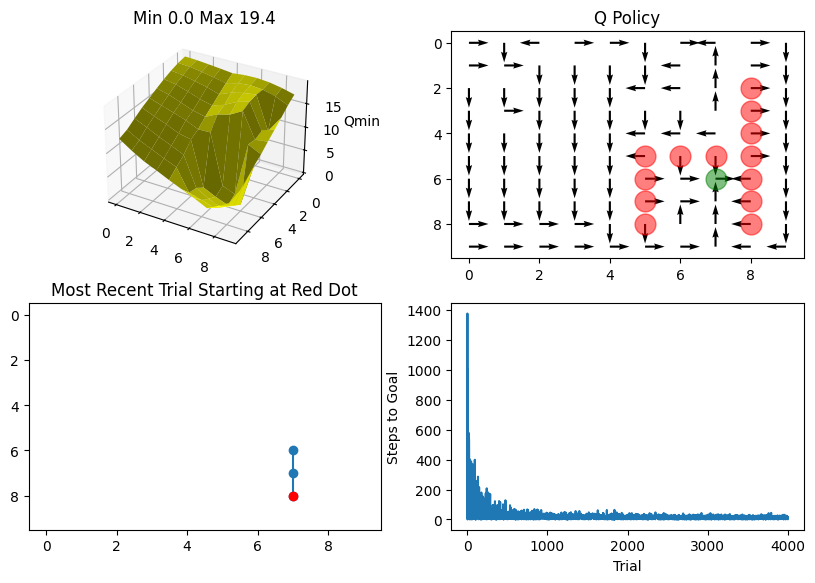

In [11]:
fig = plt.figure(figsize=(10, 10))

Q = init_Q(maze)

nSteps = 100_000
rho = 0.1
epsilon = 0.2
trace = np.zeros((nSteps, 3)) # for x, y, and a

s = np.array([1, 1])  # start position
a = 1 #first action (index)
trials = []
steps = 0
goals = 0

for step in range(nSteps):
    trace[steps, :] = s.tolist() + [a]
    here = maze[s[0] + 1, s[1] + 1]
    if here == 'G':
        # Found the Goal!
        goals += 1
        Q[s[0], s[1], a] = 0
        if steps > 0:
            Q[sold[0], sold[1], aold] += rho * (1 - Q[sold[0], sold[1], aold])

        s = np.array([np.random.randint(0, m), np.random.randint(0, n)])
        trials.append(steps)
    
    else:
        # Not goal
        steps += 1    
        Qfunc = Q 
    
        # Pick next action a
        if np.random.uniform() < epsilon:
            validActions = [a for (i, a) in enumerate(range(4)) 
                            if not np.isinf(Qfunc[s[0], s[1], i])]
            a = np.random.choice(validActions)
        else:
            a = np.argmin(Qfunc[s[0], s[1], :])

        if steps > 1:
            Q[sold[0], sold[1], aold] += rho * (1 + Q[s[0], s[1], a] - Q[sold[0], sold[1], aold])

        sold = s
        aold = a
        s = s + actions[a, :]

        # Update display each time goal is reached until reached 20 times,
        #  then update display only when number of goals reached is divisible by 100
        
    if (here == 'G' and (goals < 100 or goals % 1000 == 0)):
        
        fig.clf()
        
        ax = fig.add_subplot(3, 2, 1, projection='3d')
        showQ(Q, 'TD', ax)

        plt.subplot(3, 2, 2)
        showPolicy(Q)
        plt.title('Q Policy')

        
        plt.subplot(3, 2, 3)
        plt.plot(trace[:steps + 1, 1], trace[:steps + 1, 0], 'o-')
        plt.plot(trace[0, 1], trace[0, 0], 'ro')
        plt.xlim(0 - 0.5, 9 + 0.5)
        plt.ylim(9 + 0.5, 0 - 0.5)
        plt.title('Most Recent Trial Starting at Red Dot')
        

        plt.subplot(3, 2, 4)
        plt.plot(trials, '-')
        plt.xlabel('Trial')
        plt.ylabel('Steps to Goal')

        clear_output(wait=True)
        display(fig);

    if here == 'G':
        steps = 0
        
clear_output(wait=True)